In [1]:
import numpy
import numpy as np
import time
import datetime
import netCDF4
import matplotlib.pylab as plt
import os,sys,glob
sys.path.append(os.getcwd()+'/../adjust/rasotools/')
from utils import *
from multiprocessing import Pool
#import odb
from eccodes import *
from functools import partial
from collections import OrderedDict
import subprocess
import json
import gzip
# from retrieve_fb_jra55 import add_feedback
import copy
import pandas as pd
import matplotlib.pylab as plt

plt.rcParams['lines.linewidth'] = 3

---
---
---

In [2]:
def par_read_bufr_stn_nofeedback(varno,bufrfile):
    alldata=''
    alldict=dict()

    bufrlist=[]
    tx=time.time()
#     try:
    f = open(bufrfile)
    print(f)
    cnt = 0
    output = {}
    # loop over the messages in the file
    while 1:
        # get handle for message
        bufr = codes_bufr_new_from_file(f)
        if bufr is None:
            break
        # we need to instruct ecCodes to expand all the descriptors
        # i.e. unpack the data section
        if codes_get_array(bufr,'dataSubCategory')[0]!=109:
            codes_release(bufr)
            continue
        codes_set(bufr, 'unpack', 1)
        # get all the timePeriods
        iterid = codes_bufr_keys_iterator_new(bufr)

        # loop over the keys
        #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
            ##print (codes_get_array(bufr,'dataSubCategory')[0])
            #codes_release(bufr)
            #continue
        hires=False
        while codes_bufr_keys_iterator_next(iterid):

            # print key name
            keyname = codes_bufr_keys_iterator_get_name(iterid)
#             print(keyname,codes_get_array(bufr,keyname))
            #if keyname in ['#1#blockNumber','#1#stationNumber']:
                #print (keyname,codes_get_array(bufr,keyname))
            if 'latitudeDisplacement' in keyname:
                hires=True
        if not hires:
            codes_bufr_keys_iterator_delete(iterid)
            continue
        ## delete the key iterator
        codes_bufr_keys_iterator_delete(iterid)
        output['datum'] = float('19'+codes_get_array(bufr, "typicalDate")[0][2:])
        output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
        output['pressure'] = codes_get_array(bufr, "pressure")
        output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
        output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
        output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
        output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
        output['airTemperature'] = codes_get_array(bufr, "airTemperature")
        dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
        output['windDirection'] = codes_get_array(bufr, "windDirection")
        output['windSpeed'] = codes_get_array(bufr, "windSpeed")
        output['lat'] = codes_get(bufr, "latitude")
        output['lon'] = codes_get(bufr, "longitude")
        output['alt'] = float(codes_get(bufr, "heightOfStation"))
        output['blockNumber'] = codes_get(bufr, "blockNumber")
        output['stationNumber'] = codes_get(bufr, "stationNumber")
        return output


In [3]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202012')
sodblist.sort(key=os.path.getsize)
out = par_read_bufr_stn_nofeedback(111, sodblist[0])
# #list(map(func,  idx2))
# func = partial(par_read_bufr_stn_nofeedback,111)
# list(map(func,sodblist))

# # exit()


<_io.TextIOWrapper name='/users/staff/leo/ectrans/era5.bufr.202012' mode='r' encoding='UTF-8'>


In [4]:
out

{'datum': 19201130.0,
 'timePeriod': 213100.0,
 'pressure': array([101130., 101050., 101040., ...,   2200.,   2190.,   2000.]),
 'extendedVerticalSoundingSignificance': array([145408,      0,      0, ...,      0,  14352,  65536]),
 'geopotentialHeight': array([    7,    14,    15, ..., 26080, 26106, 26708]),
 'latitudeDisplacement': array([ 0.0000e+000,  2.5000e-004,  3.6000e-004, ...,  3.3198e-001,
         3.3197e-001, -1.0000e+100]),
 'longitudeDisplacement': array([ 0.0000e+000, -1.7000e-004, -2.5000e-004, ...,  2.1656e-001,
         2.1572e-001, -1.0000e+100]),
 'airTemperature': array([ 2.8585e+002,  2.8564e+002,  2.8552e+002, ...,  2.2031e+002,
         2.2061e+002, -1.0000e+100]),
 'windDirection': array([178, 175, 173, ...,  87,  88,   0]),
 'windSpeed': array([ 8.70e+000,  7.30e+000,  6.80e+000, ...,  1.28e+001,  1.27e+001,
        -1.00e+100]),
 'lat': -40.900000000000006,
 'lon': 174.98000000000002,
 'alt': 8.0,
 'blockNumber': 93,
 'stationNumber': 417}

In [5]:
data = pd.DataFrame.from_dict(out)
data

,datum,timePeriod,pressure,extendedVerticalSoundingSignificance,geopotentialHeight,latitudeDisplacement,longitudeDisplacement,airTemperature,windDirection,windSpeed,lat,lon,alt,blockNumber,stationNumber
0,19201130.0,213100.0,101130.0,145408,7,0.000000e+00,0.000000e+00,2.858500e+02,178,8.700000e+00,-40.9,174.98,8.0,93,417
1,19201130.0,213100.0,101050.0,0,14,2.500000e-04,-1.700000e-04,2.856400e+02,175,7.300000e+00,-40.9,174.98,8.0,93,417
2,19201130.0,213100.0,101040.0,0,15,3.600000e-04,-2.500000e-04,2.855200e+02,173,6.800000e+00,-40.9,174.98,8.0,93,417
3,19201130.0,213100.0,101010.0,0,17,4.300000e-04,-3.000000e-04,2.855200e+02,172,6.600000e+00,-40.9,174.98,8.0,93,417
4,19201130.0,213100.0,100940.0,0,23,4.800000e-04,-3.300000e-04,2.854600e+02,172,6.600000e+00,-40.9,174.98,8.0,93,417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3640,19201130.0,213100.0,2220.0,0,26019,3.320200e-01,2.182100e-01,2.197700e+02,85,1.260000e+01,-40.9,174.98,8.0,93,417
3641,19201130.0,213100.0,2210.0,0,26048,3.320000e-01,2.175000e-01,2.199900e+02,86,1.270000e+01,-40.9,174.98,8.0,93,417
3642,19201130.0,213100.0,2200.0,0,26080,3.319800e-01,2.165600e-01,2.203100e+02,87,1.280000e+01,-40.9,174.98,8.0,93,417
3643,19201130.0,213100.0,2190.0,14352,26106,3.319700e-01,2.157200e-01,2.206100e+02,88,1.270000e+01,-40.9,174.98,8.0,93,417


In [6]:
u = data.windSpeed * numpy.cos(np.radians(data.windDirection))
data['u'] = u
v = data.windSpeed * numpy.sin(np.radians(data.windDirection))
data['v'] = v

In [7]:
data

,datum,timePeriod,pressure,extendedVerticalSoundingSignificance,geopotentialHeight,latitudeDisplacement,longitudeDisplacement,airTemperature,windDirection,windSpeed,lat,lon,alt,blockNumber,stationNumber,u,v
0,19201130.0,213100.0,101130.0,145408,7,0.000000e+00,0.000000e+00,2.858500e+02,178,8.700000e+00,-40.9,174.98,8.0,93,417,-8.694700e+00,0.303626
1,19201130.0,213100.0,101050.0,0,14,2.500000e-04,-1.700000e-04,2.856400e+02,175,7.300000e+00,-40.9,174.98,8.0,93,417,-7.272221e+00,0.636237
2,19201130.0,213100.0,101040.0,0,15,3.600000e-04,-2.500000e-04,2.855200e+02,173,6.800000e+00,-40.9,174.98,8.0,93,417,-6.749314e+00,0.828712
3,19201130.0,213100.0,101010.0,0,17,4.300000e-04,-3.000000e-04,2.855200e+02,172,6.600000e+00,-40.9,174.98,8.0,93,417,-6.535769e+00,0.918542
4,19201130.0,213100.0,100940.0,0,23,4.800000e-04,-3.300000e-04,2.854600e+02,172,6.600000e+00,-40.9,174.98,8.0,93,417,-6.535769e+00,0.918542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3640,19201130.0,213100.0,2220.0,0,26019,3.320200e-01,2.182100e-01,2.197700e+02,85,1.260000e+01,-40.9,174.98,8.0,93,417,1.098162e+00,12.552053
3641,19201130.0,213100.0,2210.0,0,26048,3.320000e-01,2.175000e-01,2.199900e+02,86,1.270000e+01,-40.9,174.98,8.0,93,417,8.859072e-01,12.669063
3642,19201130.0,213100.0,2200.0,0,26080,3.319800e-01,2.165600e-01,2.203100e+02,87,1.280000e+01,-40.9,174.98,8.0,93,417,6.699002e-01,12.782458
3643,19201130.0,213100.0,2190.0,14352,26106,3.319700e-01,2.157200e-01,2.206100e+02,88,1.270000e+01,-40.9,174.98,8.0,93,417,4.432236e-01,12.692264


In [8]:
data = data[data.airTemperature < 350]
data = data[data.airTemperature > 180]
data

,datum,timePeriod,pressure,extendedVerticalSoundingSignificance,geopotentialHeight,latitudeDisplacement,longitudeDisplacement,airTemperature,windDirection,windSpeed,lat,lon,alt,blockNumber,stationNumber,u,v
0,19201130.0,213100.0,101130.0,145408,7,0.00000,0.00000,285.85,178,8.7,-40.9,174.98,8.0,93,417,-8.694700,0.303626
1,19201130.0,213100.0,101050.0,0,14,0.00025,-0.00017,285.64,175,7.3,-40.9,174.98,8.0,93,417,-7.272221,0.636237
2,19201130.0,213100.0,101040.0,0,15,0.00036,-0.00025,285.52,173,6.8,-40.9,174.98,8.0,93,417,-6.749314,0.828712
3,19201130.0,213100.0,101010.0,0,17,0.00043,-0.00030,285.52,172,6.6,-40.9,174.98,8.0,93,417,-6.535769,0.918542
4,19201130.0,213100.0,100940.0,0,23,0.00048,-0.00033,285.46,172,6.6,-40.9,174.98,8.0,93,417,-6.535769,0.918542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3639,19201130.0,213100.0,2230.0,0,25991,0.33203,0.21890,219.65,84,12.5,-40.9,174.98,8.0,93,417,1.306606,12.431524
3640,19201130.0,213100.0,2220.0,0,26019,0.33202,0.21821,219.77,85,12.6,-40.9,174.98,8.0,93,417,1.098162,12.552053
3641,19201130.0,213100.0,2210.0,0,26048,0.33200,0.21750,219.99,86,12.7,-40.9,174.98,8.0,93,417,0.885907,12.669063
3642,19201130.0,213100.0,2200.0,0,26080,0.33198,0.21656,220.31,87,12.8,-40.9,174.98,8.0,93,417,0.669900,12.782458


---
---

In [27]:
def calc_height(t, p):
    '''
    z = -R*t0/g * ln(p/p0)
    z = -287.053*t0/9.80665 * ln(p/p0)
    '''
    z = []
    for i in range(len(t)):
        if i == 0:
            z.append(0)
        else:
            height = -287.053*numpy.mean(t)/9.80665 * numpy.log(p[i]/p[0])
            z.append(height)
    return z

# to gpm
from scipy.integrate import quad

def integrand(x):
    return (6371000 / (6371000 + x))**2
def expint(x):
    return quad(integrand, 0, x,)[0]




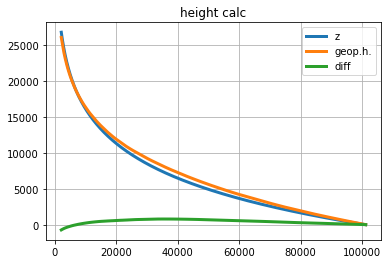

In [37]:
z = calc_height(data.airTemperature, data.pressure)
# vec_expint = numpy.vectorize(expint)
# z = vec_expint(z)

plt.plot(data.pressure,z,label='z')
plt.plot(data.pressure,data.geopotentialHeight,label='geop.h.')
plt.plot(data.pressure,data.geopotentialHeight-z,label='diff')
plt.title('height calc')
plt.legend()
plt.grid()
plt.show()

In [11]:
# reduced = data[numpy.isin(data.pressure, [100000,85000,75000,50000,40000,30000,20000,10000,5000,3000,1000])]
# z = calc_height(reduced.airTemperature, reduced.pressure)
# vec_expint = numpy.vectorize(expint)
# z = vec_expint(z)

# plt.plot(reduced.pressure,z,label='z')
# plt.plot(data.pressure,data.geopotentialHeight,label='geop.h.')
# plt.title('height calc')
# plt.legend()
# plt.grid()
# plt.show()

---
---

In [12]:
def inverse_haversine(lat, lon, distance, direction):
    '''
    distance: [km]
    '''
    lat = numpy.radians(lat)
    lon = numpy.radians(lon)
    d = numpy.array(distance)
    r = 6371 #[km]
    if direction == "NORTH":
        brng = 0.
    elif direction == "EAST":
        brng = 1.5707963267948966
    else:
        return "error - not a valid direction"
    return_lat = numpy.arcsin(numpy.sin(lat) * numpy.cos(d / r) + numpy.cos(lat) * numpy.sin(d / r) * numpy.cos(brng))
    return_lon = lon + numpy.arctan2(numpy.sin(brng) * numpy.sin(d / r) * numpy.cos(lat), numpy.cos(d / r) - numpy.sin(lat) * numpy.sin(return_lat))

    return numpy.degrees(return_lat), numpy.degrees(return_lon)

In [15]:
# from haversine import inverse_haversine, Direction
def transport(lat, lon, u_dist, v_dist):
    '''
    dist: [km]
    '''
    new_lat, new_lon = inverse_haversine(lat, lon, u_dist, "EAST")
    new_lat, new_lon = inverse_haversine(new_lat, new_lon, v_dist, "NORTH")
    return new_lat, new_lon

In [16]:
lat = data.lat.iloc[0]
lon = data.lon.iloc[0]
print(lat, lon)
print(transport(lat, lon, [111,-111],[0,0]))

print(transport(lat, lon, 100,0))
print(transport(lat, lon, -100,0))

print(transport(lat, lon, 0,100))
print(transport(lat, lon, 0,-100))

-40.900000000000006 174.98000000000002
(array([-40.89246784, -40.89246784]), array([176.30058825, 173.65941175]))
(-40.89388663614691, 176.16973615202468)
(-40.89388663614691, 173.79026384797538)
(-40.00067839408128, 174.98000000000002)
(-41.79932160591875, 174.98000000000002)


---
---

In [63]:
def trajectory(lat, lon, u, v, pressure, temperature, w_rs = 5.5):
    '''
    w_rs -> radio sonde rising speed
    '''
    z = calc_height(temperature, pressure) # m from K and Pa
    print(temperature, pressure)
#     vec_expint = numpy.vectorize(expint)
#     z = vec_expint(z)
    
    lat_displacement = [0.]
    lon_displacement = [0.]
    
    for i in range(len(z)):
        if i == 0:
            new_lat = lat
            new_lon = lon
        else:
            rising_time = (z[i]-z[i-1]) / w_rs
#             print(z[i], z[i-1], z[i]-z[i-1], rising_time)
            new_lat, new_lon = transport(new_lat, new_lon, (np.mean([u[i],u[i-1]]) * rising_time)/1000., (np.mean([v[i],v[i-1]]) * rising_time)/1000.)
#             new_lat, new_lon = transport(new_lat, new_lon, (u[i] * rising_time)/1000., (v[i] * rising_time)/1000.)
            lat_displacement.append(lat - new_lat)
            lon_displacement.append(lon - new_lon)
#         lat_displacement.append(new_lat)
#         lon_displacement.append(new_lon)

    return lat_displacement, lon_displacement


In [64]:
lat_displacement, lon_displacement = trajectory(np.array(data.lat)[0], np.array(data.lon)[0], np.array(data.u), np.array(data.v), np.array(data.pressure), np.array(data.airTemperature))

[285.85 285.64 285.52 ... 219.99 220.31 220.61] [101130. 101050. 101040. ...   2210.   2200.   2190.]


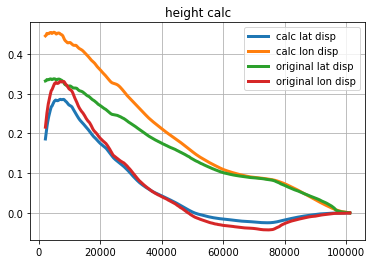

In [65]:
plt.plot(data.pressure,np.array(lat_displacement),label='calc lat disp')
plt.plot(data.pressure,np.array(lon_displacement),label='calc lon disp')
plt.plot(data.pressure,data.latitudeDisplacement,label='original lat disp')
plt.plot(data.pressure,data.longitudeDisplacement,label='original lon disp')

plt.title('height calc')
plt.legend()
plt.grid()
plt.show()

In [66]:
reduced = data[numpy.isin(data.pressure, [100000,85000,75000,50000,40000,30000,20000,10000,5000,3000,1000])]
lat_displacement, lon_displacement = trajectory(np.array(reduced.lat)[0], np.array(reduced.lon)[0], np.array(reduced.u), np.array(reduced.v), np.array(reduced.pressure), np.array(reduced.airTemperature))

[284.67 274.17 259.41 245.79 228.56 223.15 217.35 217.16 218.42] [100000.  85000.  50000.  40000.  30000.  20000.  10000.   5000.   3000.]


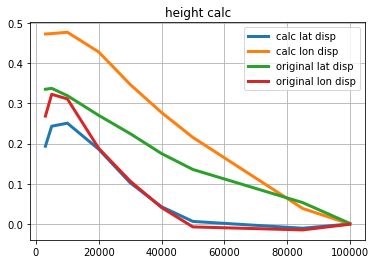

In [67]:
plt.plot(reduced.pressure,lat_displacement,label='calc lat disp')
plt.plot(reduced.pressure,lon_displacement,label='calc lon disp')
plt.plot(reduced.pressure,reduced.latitudeDisplacement,label='original lat disp')
plt.plot(reduced.pressure,reduced.longitudeDisplacement,label='original lon disp')

plt.title('height calc')
plt.legend()
plt.grid()
plt.show()